# Acquire/Prepare Exercises


### 1. Acquire bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, and fips from the zillow database for all 'Single Family Residential' properties.

In [1]:
## Import modules

import pandas as pd
import numpy as np
import os
from env import host, user, password

import warnings
warnings.filterwarnings("ignore")

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import sklearn.metrics
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from wrangle import wrangle_zillow

In [2]:
## Data query and return df, save a csv

def get_connection(db, user=user, host=host, password=password):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    It takes in a string name of a database as an argument.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'
    
    
def new_zillow_data():
    '''
    This function reads the Bed/Bath count, Finished Sq Ft, Taxable Value, Year Built, and Amount Taxed
    from the 2017 Properties Zillow data from the Codeup SQL server into a df.
    '''
    sql_query = """
                SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, 
                       taxvaluedollarcnt, yearbuilt, taxamount, fips
                FROM properties_2017
                WHERE propertylandusetypeid LIKE '261' OR propertylandusetypeid LIKE '279'
                """
    
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('zillow'))
    
    return df

def get_zillow_data():
    '''
    This function reads in zillow data from the Codeup database, writes data to
    a csv file if a local file does not exist, and returns a df.
    '''
    if os.path.isfile('zillow.csv'):
        
        # If csv file exists read in data from csv file.
        df = pd.read_csv('zillow.csv', index_col=0)
        
    else:
        
        # Read fresh data from db into a DataFrame
        df = new_zillow_data()
        
        # Cache data
        df.to_csv('zillow.csv')
        
    return df

In [3]:
# test get data function

df = get_zillow_data()
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


### 2. Using your acquired Zillow data, walk through the summarization and cleaning steps in your wrangle.ipynb file like we did above. You may handle the missing values however you feel is appropriate and meaninful; remember to document your process and decisions using markdown and code commenting where helpful.

In [4]:
df.shape

(2152864, 7)

In [28]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1656557 entries, 7 to 2152854
Data columns (total 7 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   bedroomcnt                    1656557 non-null  int64  
 1   bathroomcnt                   1656557 non-null  int64  
 2   calculatedfinishedsquarefeet  1656557 non-null  int64  
 3   taxvaluedollarcnt             1656557 non-null  int64  
 4   yearbuilt                     1656557 non-null  int64  
 5   taxamount                     1656557 non-null  float64
 6   fips                          1656557 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 101.1 MB


In [6]:
# count nulls
df.isnull().sum()

bedroomcnt                        11
bathroomcnt                       11
calculatedfinishedsquarefeet    8485
taxvaluedollarcnt                493
yearbuilt                       9338
taxamount                       4442
fips                               0
dtype: int64

### Handling Nulls
#### Removing outliers takes care of nulls in this instance, but if it did not, this is how I would handle nulls.
- bedroomcount can be filled with average
- bathroomcount can be filled with average
- calculatedfinishedsquarefeet will be dropped due to amount of records
- taxvaluedollarcnt will also be dropped
- yearbuilt will also be dropped due to amount of records
- taxamount will also be dropped due to amount of records

In [7]:
# fill bedroomcnt na with mean
df['bedroomcnt'] = df['bedroomcnt'].fillna(value = df.bedroomcnt.mean())
# fill bathroomcnt na with mean
df['bathroomcnt'] = df['bathroomcnt'].fillna(value = df.bedroomcnt.mean())
# drop other col's na
df = df.dropna()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140235 entries, 4 to 2152863
Data columns (total 7 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   bedroomcnt                    float64
 1   bathroomcnt                   float64
 2   calculatedfinishedsquarefeet  float64
 3   taxvaluedollarcnt             float64
 4   yearbuilt                     float64
 5   taxamount                     float64
 6   fips                          float64
dtypes: float64(7)
memory usage: 130.6 MB


In [9]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0
6,3.0,4.0,1620.0,847770.0,2011.0,10244.94,6037.0
7,3.0,2.0,2077.0,646760.0,1926.0,7924.68,6037.0
11,0.0,0.0,1200.0,5328.0,1972.0,91.60,6037.0
14,0.0,0.0,171.0,6920.0,1973.0,255.17,6037.0


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,2140235.0,3.301419,0.932600,0.00,3.00,3.00,4.00,25.00
bathroomcnt,2140235.0,2.240352,0.990549,0.00,2.00,2.00,3.00,32.00
calculatedfinishedsquarefeet,2140235.0,1863.193970,1221.754161,1.00,1258.00,1623.00,2208.00,952576.00
taxvaluedollarcnt,2140235.0,460641.625164,677157.635675,22.00,189166.00,328296.00,534606.00,90188462.00
yearbuilt,2140235.0,1960.967545,22.150563,1801.00,1949.00,1958.00,1976.00,2016.00
taxamount,2140235.0,5616.711322,7814.562798,6.34,2540.85,4111.47,6411.93,1078101.87
fips,2140235.0,6048.309556,20.344910,6037.00,6037.00,6037.00,6059.00,6111.00


In [11]:
cols = df.columns.to_list()



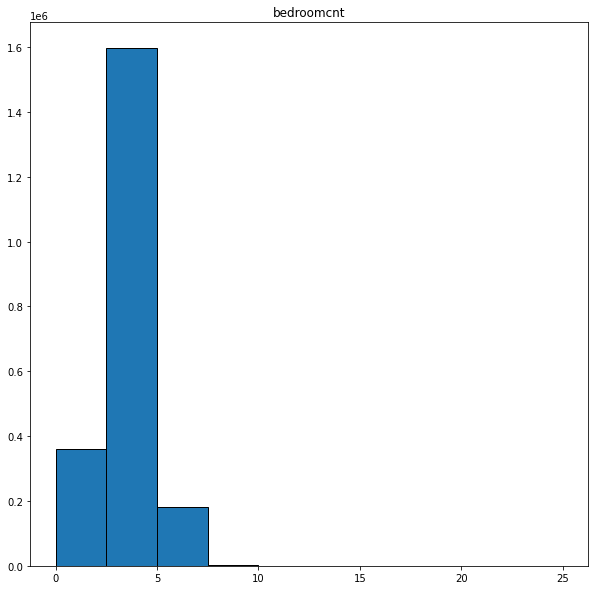

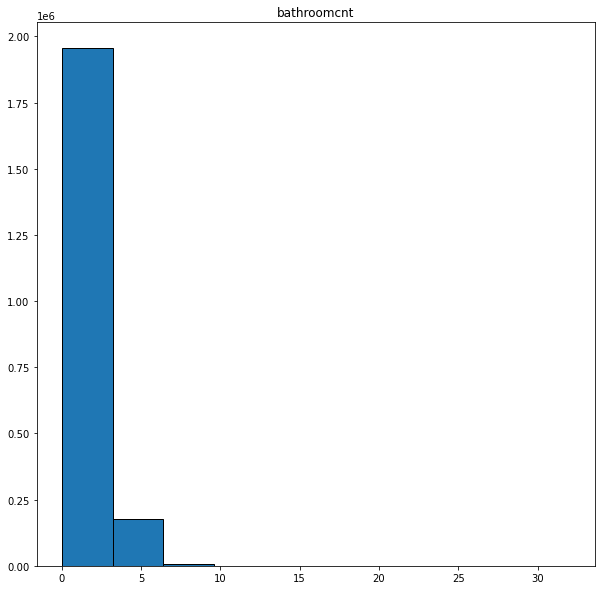

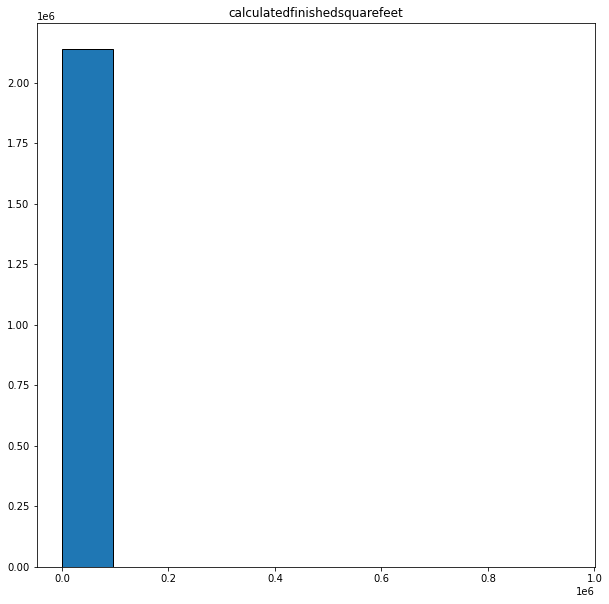

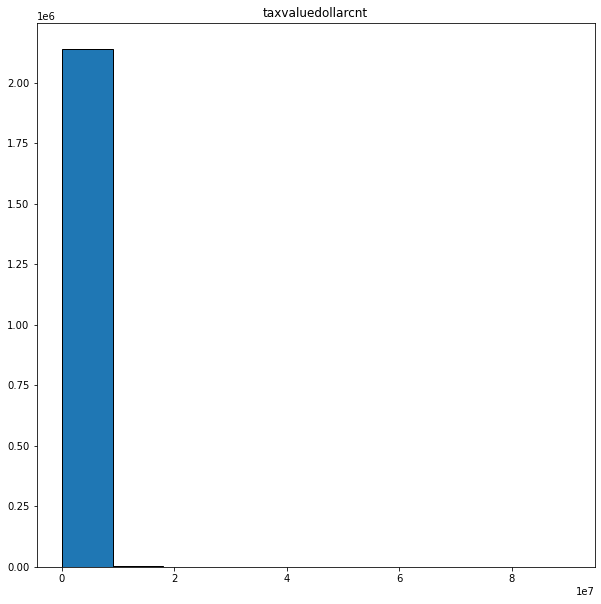

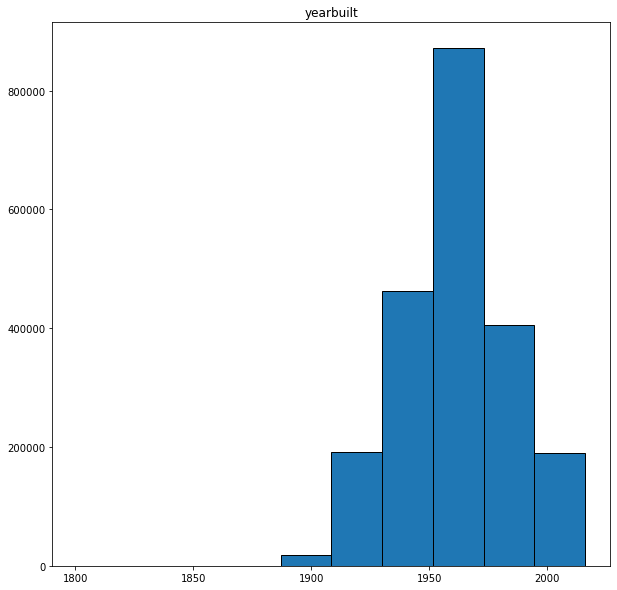

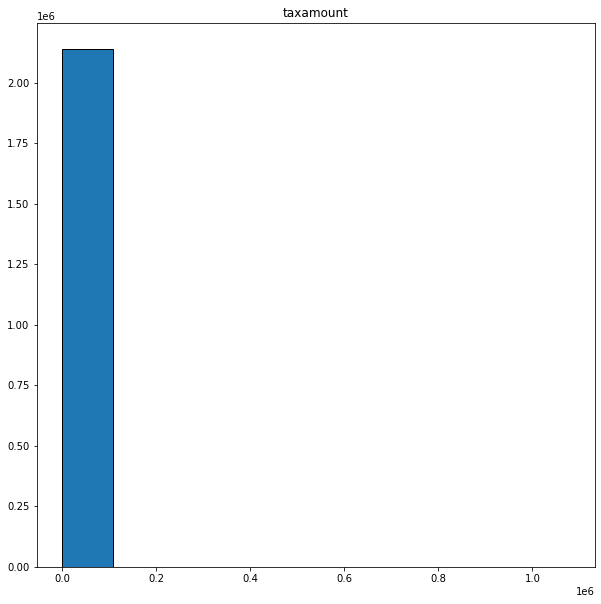

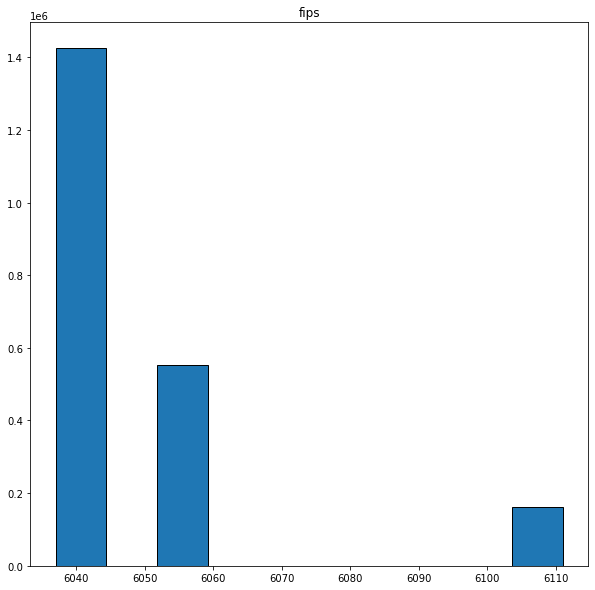

In [12]:
cols = df.columns.to_list()

for i, col in enumerate(cols):
    
    # i starts at 0, but plot numbers should start at 1
    plot_number = i + 1 
    
    # Create subplot.
    plt.figure(figsize = (10,10))
    
    # Title with column name.
    plt.title(col)
    
    # Display histogram for column.
    df[col].hist(edgecolor='black')
    
    # Hide gridlines.
    plt.grid(False)

In [13]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [14]:
df = remove_outliers(df, 1.5, cols)

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,1656458.0,3.196504,0.776270,2.00,3.0000,3.000,4.00,5.00
bathroomcnt,1656458.0,2.046373,0.705848,1.00,2.0000,2.000,2.50,4.00
calculatedfinishedsquarefeet,1656458.0,1639.877839,559.157535,1.00,1223.0000,1534.000,1966.00,3408.00
taxvaluedollarcnt,1656458.0,325127.022304,198008.585727,22.00,171000.0000,293220.500,448262.50,950835.00
yearbuilt,1656458.0,1959.072444,18.693919,1915.00,1949.0000,1956.000,1971.00,2006.00
taxamount,1656458.0,4060.414533,2232.384661,18.72,2356.9625,3732.195,5472.98,10328.87
fips,1656458.0,6043.131322,9.863875,6037.00,6037.0000,6037.000,6059.00,6059.00


In [16]:
# change all but taxamount to int datatypes.
for col in df.columns[df.columns != 'taxamount']:
    df[col] = df[col].astype(int)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1656458 entries, 7 to 2152854
Data columns (total 7 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   bedroomcnt                    1656458 non-null  int64  
 1   bathroomcnt                   1656458 non-null  int64  
 2   calculatedfinishedsquarefeet  1656458 non-null  int64  
 3   taxvaluedollarcnt             1656458 non-null  int64  
 4   yearbuilt                     1656458 non-null  int64  
 5   taxamount                     1656458 non-null  float64
 6   fips                          1656458 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 101.1 MB


In [18]:
df.drop_duplicates()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
7,3,2,2077,646760,1926,7924.68,6037
18,3,1,1244,169471,1950,2532.88,6037
19,3,2,1300,233266,1950,3110.99,6037
20,3,2,1222,290492,1951,3870.25,6037
40,2,1,725,37548,1953,576.47,6037
...,...,...,...,...,...,...,...
2152813,5,2,1945,243668,1948,3163.93,6037
2152815,2,2,1270,178191,1936,2285.20,6037
2152816,4,2,1484,71859,1955,1135.72,6037
2152832,3,2,1194,271536,1954,3555.73,6037


### 3. Store all of the necessary functions to automate your process from acquiring the data to returning a cleaned dataframe witn no missing values in your wrangle.py file. Name your final function wrangle_zillow.

In [36]:
import wrangle

In [37]:
df = wrangle.get_zillow_data()

In [38]:
df = wrangle.prepare(df)

In [40]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
7,3,2,2077,646760,1926,7924.68,6037
18,3,1,1244,169471,1950,2532.88,6037
19,3,2,1300,233266,1950,3110.99,6037
20,3,2,1222,290492,1951,3870.25,6037
40,2,1,725,37548,1953,576.47,6037


In [24]:
train, validate, test = wrangle.split_zillow(df)
# or import the wrangle_zillow function to do it all
# from wrangle import wrangle_zillow
# train, validate, test = wrangle_zillow()

In [35]:
train.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
1462930,3,2,1385,123859,1956,1553.44,6059
1842132,4,2,1567,251569,1946,3074.99,6037
869730,4,2,1910,762153,1958,8578.06,6059
1306111,3,2,2042,751716,1936,9122.39,6037
431629,3,2,1502,351732,1956,4343.63,6037
